# Formula 1 Grand Prix result prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
plt.style.use('seaborn')

In [2]:
results = pd.read_csv(r'data\results.csv')
races = pd.read_csv(r'data\races.csv')
quali = pd.read_csv(r'data\qualifying.csv')
drivers = pd.read_csv(r'data\drivers.csv')
constructors = pd.read_csv(r'data\constructors.csv')
circuit = pd.read_csv(r'data\circuits.csv')

In [3]:
df1 = pd.merge(races,results,how='inner',on=['raceId'])
df2 = pd.merge(df1,quali,how='inner',on=['raceId','driverId','constructorId'])
df3 = pd.merge(df2,drivers,how='inner',on=['driverId'])
df4 = pd.merge(df3,constructors,how='inner',on=['constructorId'])
df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'])

Index(['raceId', 'year', 'round', 'circuitId', 'name_x', 'date', 'time_x',
       'url_x', 'resultId', 'driverId', 'constructorId', 'number_x', 'grid',
       'position_x', 'positionText', 'positionOrder', 'points', 'laps',
       'time_y', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'qualifyId', 'number_y', 'position_y',
       'q1', 'q2', 'q3', 'driverRef', 'number', 'code', 'forename', 'surname',
       'dob', 'nationality_x', 'url_y', 'constructorRef', 'name_y',
       'nationality_y', 'url_x', 'circuitRef', 'name', 'location', 'country',
       'lat', 'lng', 'alt', 'url_y'],
      dtype='object')

In [18]:
data.head()

,year,date,quali_pos,statusId,position,dob,driver_nationality,constructor,constructor_nationality,GP_name,country,driver,age_at_gp_in_days,driver_home,constructor_home,driver_dnf,constructor_dnf
26,2011,2011-03-27,18,11,18,1977-05-10,Ger,Renault,Fre,Albert Park Grand Prix Circuit,Aus,Nick Heidfeld,12374,0,0,0,1
30,2010,2010-03-28,9,1,9,1984-12-07,Pol,Renault,Fre,Albert Park Grand Prix Circuit,Aus,Robert Kubica,9242,0,0,0,0
34,2017,2017-03-26,11,11,12,1987-08-19,Ger,Renault,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,10812,0,0,0,1
35,2018,2018-03-25,7,1,8,1987-08-19,Ger,Renault,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,11176,0,0,0,0
36,2019,2019-03-17,11,11,11,1987-08-19,Ger,Renault,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,11533,0,0,0,1


In [4]:
#drop the columns which are not important
data = df5.drop(['round','circuitId','time_x','url_x','resultId','driverId',
                 'constructorId','number_x','positionText','position_x',
                 'positionOrder','laps','time_y','rank',
                 'fastestLapTime','fastestLapSpeed','qualifyId','driverRef','number','code','url_y','circuitRef',
                 'location','lat','lng','alt','number_y','points','constructorRef','name_x','raceId','fastestLap','q2','q3','milliseconds','q1'],1)

In [5]:
#considering data points from 1980
data = data[data['year']>=1980]

In [135]:
data_new = data[data['year'] == 2018]

In [14]:
data_new

,year,date,quali_pos,statusId,position,forename,surname,dob,driver_nationality,constructor,constructor_nationality,GP_name,country,driver,age_at_gp_in_days
35,2018,2018-03-25,7,1,8,Nico,Hülkenberg,1987-08-19,German,Renault,French,Albert Park Grand Prix Circuit,Australia,Nico Hülkenberg,11176
41,2018,2018-03-25,9,1,9,Carlos,Sainz,1994-09-01,Spanish,Renault,French,Albert Park Grand Prix Circuit,Australia,Carlos Sainz,8606
95,2018,2018-03-25,13,1,14,Lance,Stroll,1998-10-29,Canadian,Williams,British,Albert Park Grand Prix Circuit,Australia,Lance Stroll,7087
96,2018,2018-03-25,19,23,19,Sergey,Sirotkin,1995-08-27,Russian,Williams,British,Albert Park Grand Prix Circuit,Australia,Sergey Sirotkin,8246
108,2018,2018-03-25,10,1,11,Fernando,Alonso,1981-07-29,Spanish,McLaren,British,Albert Park Grand Prix Circuit,Australia,Fernando Alonso,13388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8052,2018,2018-06-24,8,1,8,Charles,Leclerc,1997-10-16,Monegasque,Sauber,Swiss,Circuit Paul Ricard,France,Charles Leclerc,7556
8053,2018,2018-06-24,5,1,5,Daniel,Ricciardo,1989-07-01,Australian,Red Bull,Austrian,Circuit Paul Ricard,France,Daniel Ricciardo,10585
8054,2018,2018-06-24,4,1,4,Max,Verstappen,1997-09-30,Dutch,Red Bull,Austrian,Circuit Paul Ricard,France,Max Verstappen,7572
8059,2018,2018-06-24,10,11,10,Romain,Grosjean,1986-04-17,French,Haas F1 Team,American,Circuit Paul Ricard,France,Romain Grosjean,11756


In [6]:
#rename the columns
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

In [7]:
#creating a driver age parameter
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

In [8]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Aston Martin' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Alpine' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [9]:
data['driver_nationality'] = data['driver_nationality'].apply(lambda x: str(x)[:3])
data['constructor_nationality'] = data['constructor_nationality'].apply(lambda x: str(x)[:3])
data['country'] = data['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data['country'] = data['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data['country'] = data['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data['country'] = data['country'].apply(lambda x: str(x)[:3])
data['driver_home'] = data['driver_nationality'] == data['country']
data['constructor_home'] = data['constructor_nationality'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

In [10]:
#reasons for DNF(did not finish)
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)
data.drop(['forename','surname'],1,inplace=True)

In [161]:
data.head()

,year,date,quali_pos,statusId,position,dob,driver_nationality,constructor,constructor_nationality,GP_name,country,driver,age_at_gp_in_days,driver_home,constructor_home,driver_dnf,constructor_dnf
26,2011,2011-03-27,18,11,18,1977-05-10,Ger,Renault,Fre,Albert Park Grand Prix Circuit,Aus,Nick Heidfeld,12374,0,0,0,1
30,2010,2010-03-28,9,1,9,1984-12-07,Pol,Renault,Fre,Albert Park Grand Prix Circuit,Aus,Robert Kubica,9242,0,0,0,0
34,2017,2017-03-26,11,11,12,1987-08-19,Ger,Renault,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,10812,0,0,0,1
35,2018,2018-03-25,7,1,8,1987-08-19,Ger,Renault,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,11176,0,0,0,0
36,2019,2019-03-17,11,11,11,1987-08-19,Ger,Renault,Fre,Albert Park Grand Prix Circuit,Aus,Nico Hülkenberg,11533,0,0,0,1


In [11]:
font = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':10
}

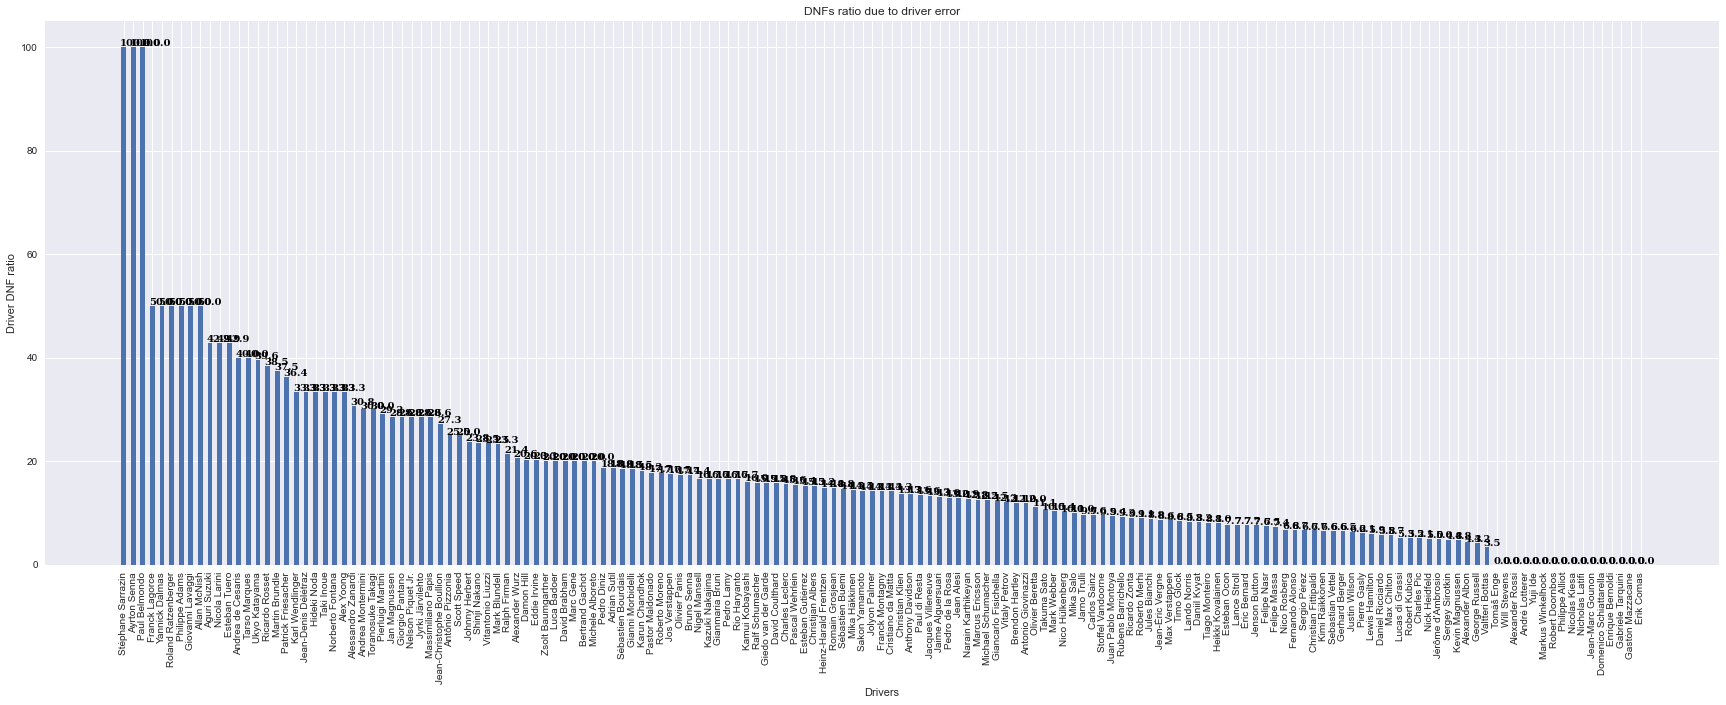

In [92]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver*100/driver_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_dnf_ratio.index,height=driver_dnf_ratio,align='center',width=0.5)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('Driver DNF ratio')
plt.title('DNFs ratio due to driver error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.1,yval+0.15,f'{round(yval,1)}',fontdict=font)
plt.show()

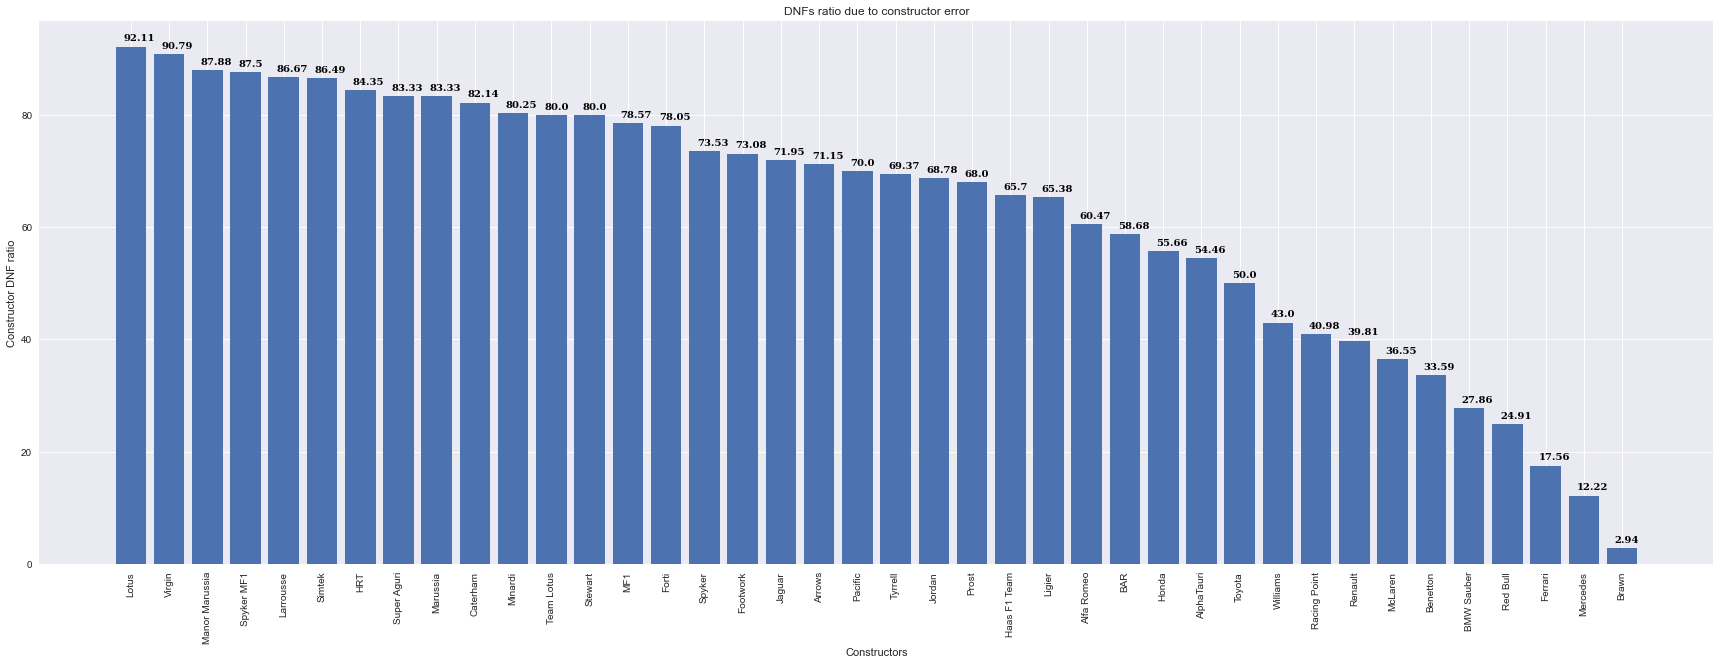

In [22]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor*100/constructor_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_dnf_ratio.index,height=constructor_dnf_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('Constructor DNF ratio')
plt.title('DNFs ratio due to constructor error')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.21,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

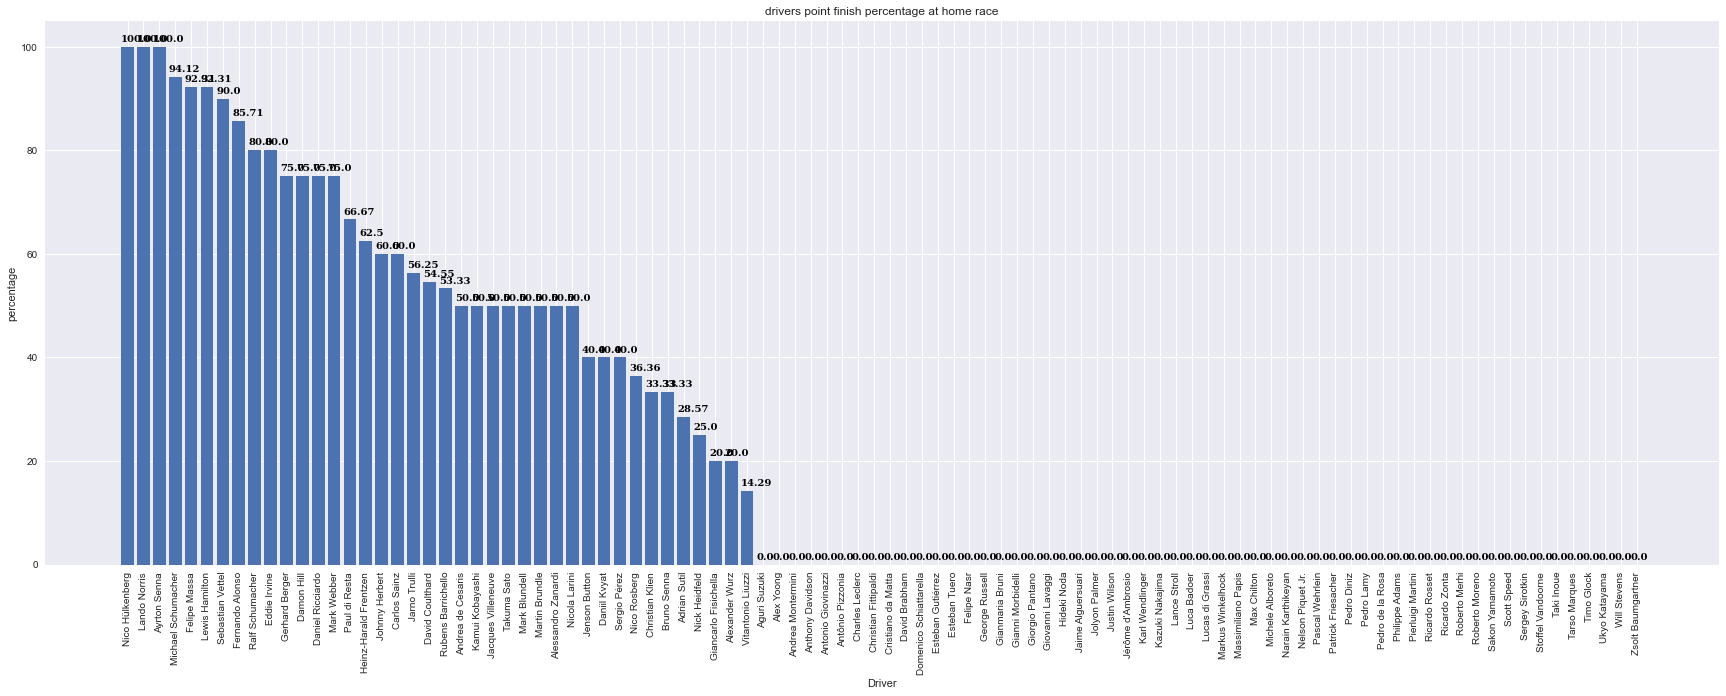

In [25]:
driver_home_points_finish = data.loc[(data['position']<11)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver').sum()['driver_home']
driver_home_point_finish_ratio = (driver_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_point_finish_ratio.index,height=driver_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Driver')
plt.ylabel('percentage')
plt.title('drivers point finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

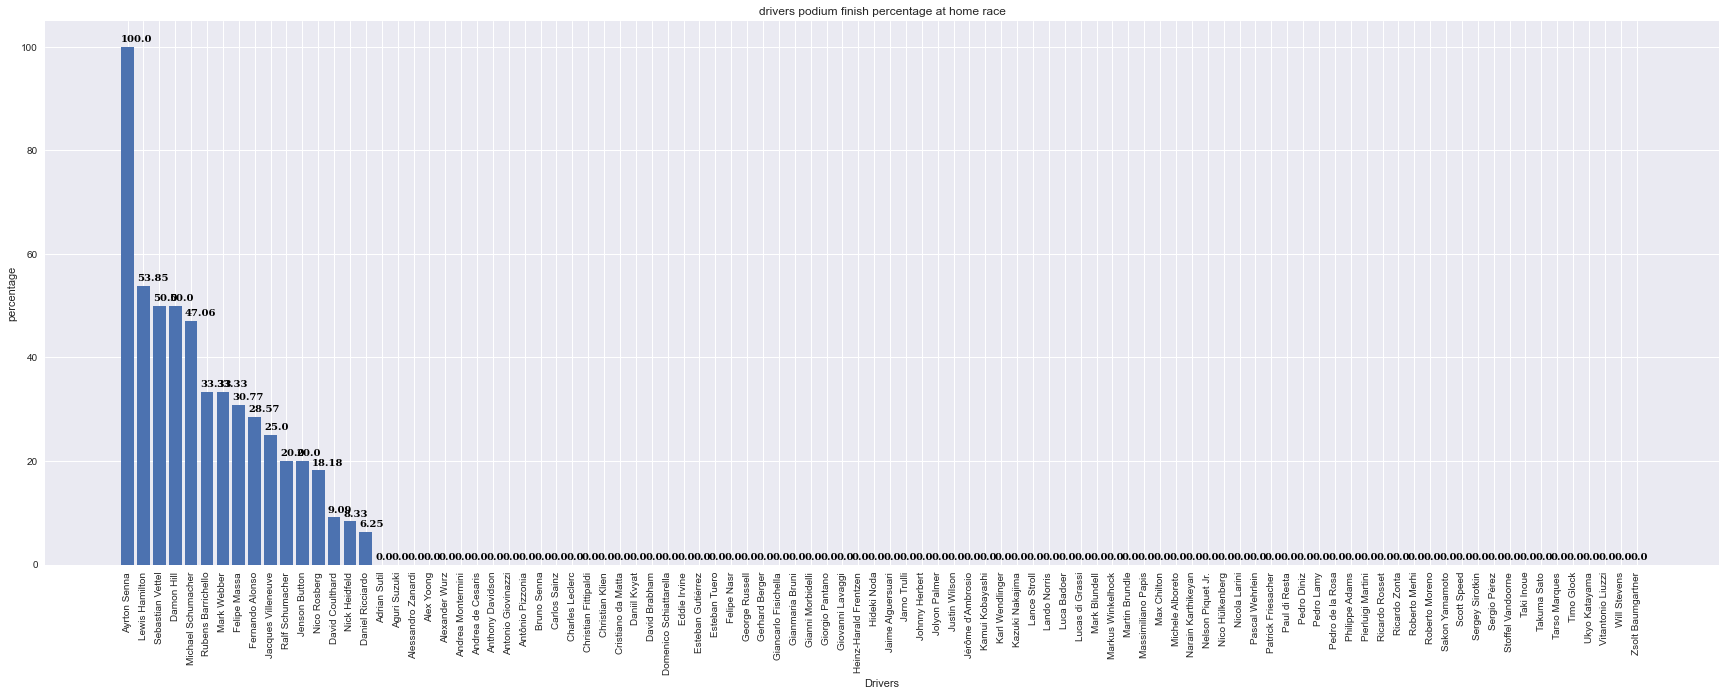

In [24]:
driver_home_podium_finish = data.loc[(data['position']<4)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver').sum()['driver_home']
driver_home_podium_finish_ratio = (driver_home_podium_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_podium_finish_ratio.index,height=driver_home_podium_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Drivers')
plt.ylabel('percentage')
plt.title('drivers podium finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

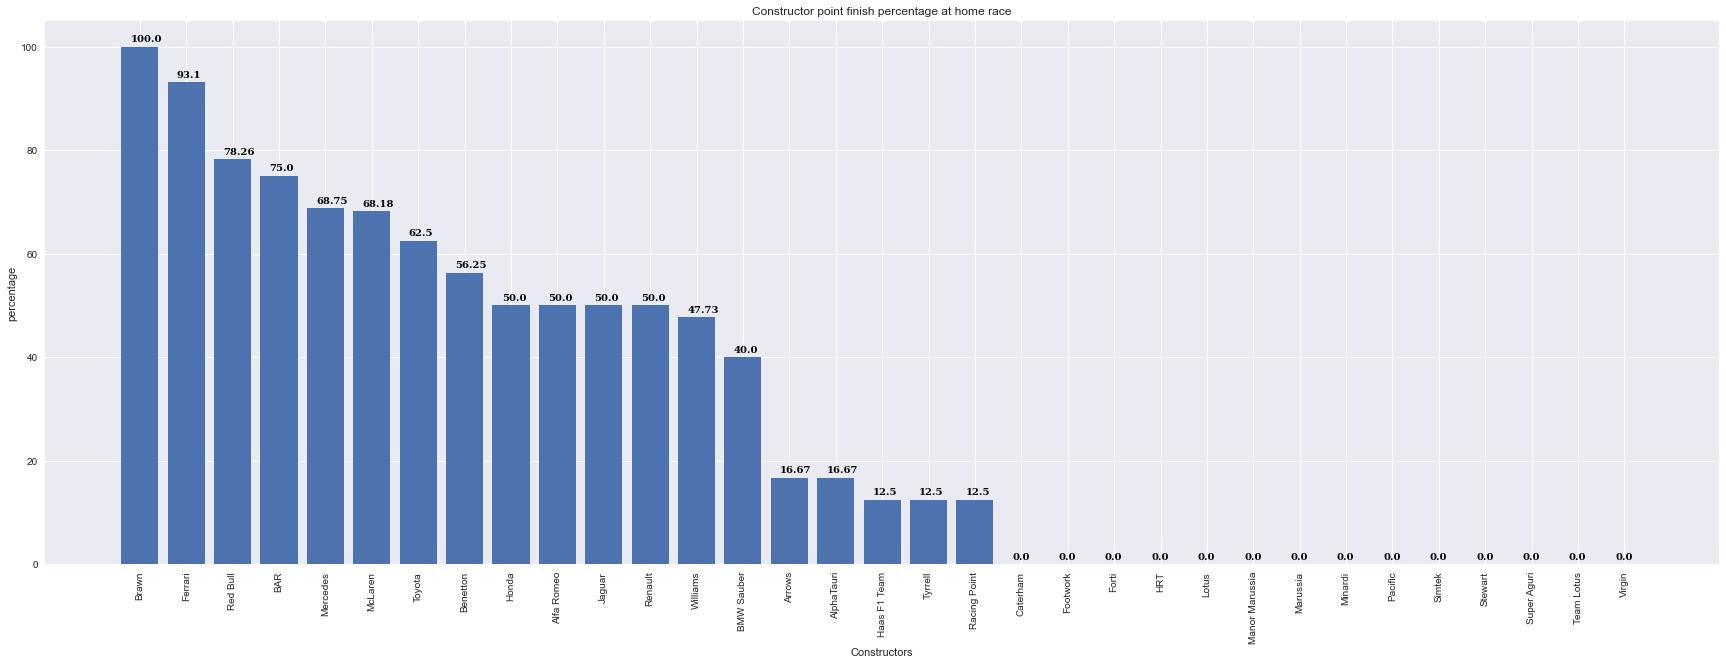

In [26]:
constructor_home_points_finish = data.loc[(data['position']<11)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor').sum()['constructor_home']
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('percentage')
plt.title('Constructor point finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

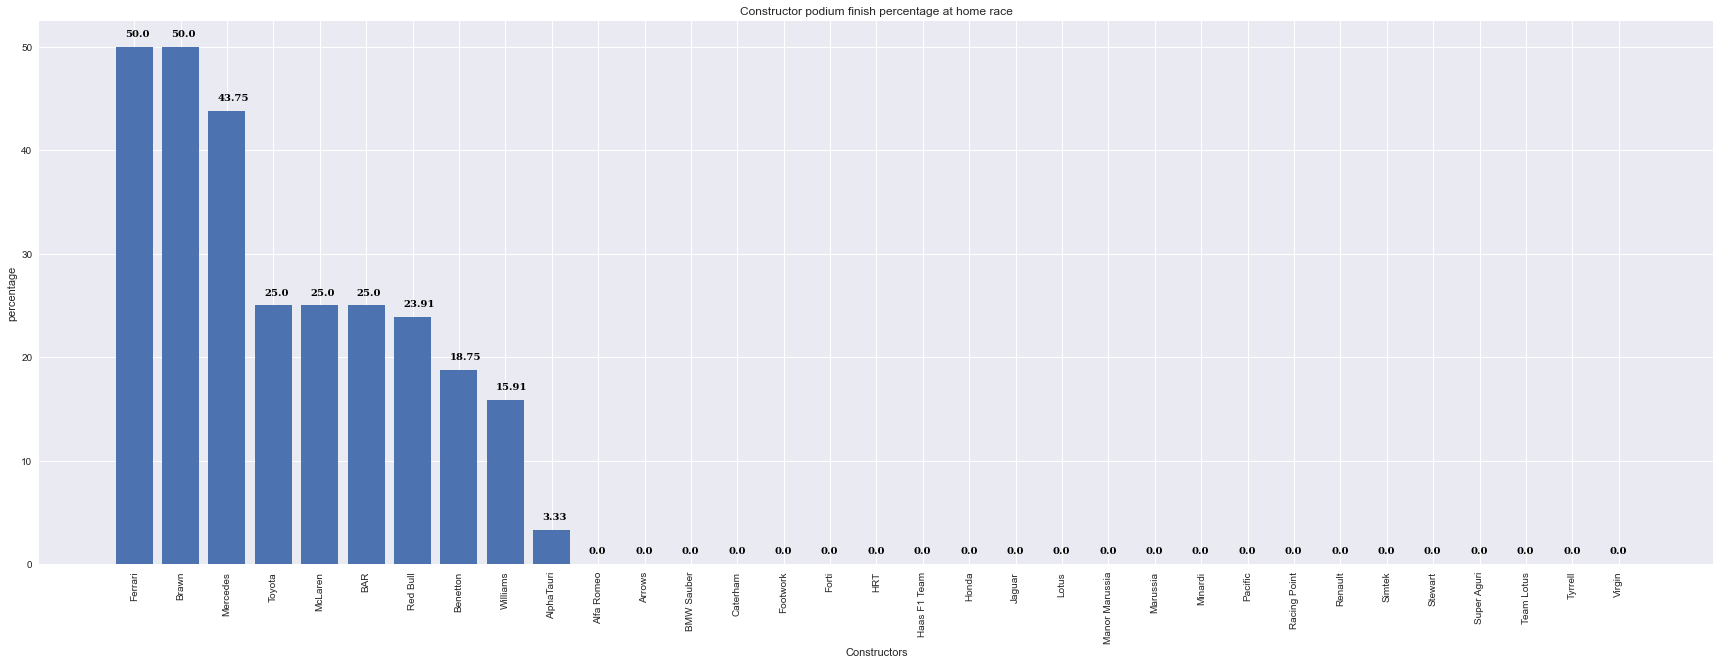

In [27]:
constructor_home_points_finish = data.loc[(data['position']<4)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor').sum()['constructor_home']
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Constructors')
plt.ylabel('percentage')
plt.title('Constructor podium finish percentage at home race')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

In [12]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
driver_confidence = 1-driver_dnf_ratio
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

In [13]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
constructor_relaiblity = 1-constructor_dnf_ratio
constructor_relaiblity_dict = dict(zip(constructor_relaiblity.index,constructor_relaiblity))

In [14]:
data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
data['constructor_relaiblity'] = data['constructor'].apply(lambda x:constructor_relaiblity_dict[x])
#removing retired drivers and constructors
active_constructors = ['Renault', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Racing Point', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Daniel Ricciardo', 'Kevin Magnussen', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Sebastian Vettel', 'Kimi Räikkönen',
                  'Charles Leclerc', 'Lewis Hamilton', 'Daniil Kvyat',
                  'Max Verstappen', 'Pierre Gasly', 'Alexander Albon',
                  'Sergio Pérez', 'Esteban Ocon', 'Antonio Giovinazzi',
                  'Romain Grosjean','Nicholas Latifi']
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

### Model considering both drivers and constructors

In [15]:
cleaned_data = data[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_relaiblity','active_driver','active_constructor','dob']]
cleaned_data = cleaned_data[(cleaned_data['active_driver']==1)&(cleaned_data['active_constructor']==1)]
#cleaned_data.to_csv('cleaned_data.csv',index=False)


In [214]:
cleaned_data

,GP_name,quali_pos,constructor,driver,position,driver_confidence,constructor_relaiblity,active_driver,active_constructor,dob
39,Albert Park Grand Prix Circuit,12,Renault,Daniel Ricciardo,12,0.942197,0.601852,1,1,1989-07-01
40,Albert Park Grand Prix Circuit,14,Renault,Kevin Magnussen,15,0.952381,0.601852,1,1,1992-10-05
41,Albert Park Grand Prix Circuit,9,Renault,Carlos Sainz,9,0.903846,0.601852,1,1,1994-09-01
90,Albert Park Grand Prix Circuit,16,Williams,Valtteri Bottas,16,0.965035,0.569961,1,1,1989-08-28
91,Albert Park Grand Prix Circuit,15,Williams,Valtteri Bottas,10,0.965035,0.569961,1,1,1989-08-28
...,...,...,...,...,...,...,...,...,...,...
8122,Buddh International Circuit,1,Red Bull,Sebastian Vettel,1,0.934156,0.750865,1,1,1987-07-03
8123,Buddh International Circuit,7,Renault,Kimi Räikkönen,7,0.933798,0.601852,1,1,1979-10-17
8124,Buddh International Circuit,6,Renault,Kimi Räikkönen,6,0.933798,0.601852,1,1,1979-10-17
8125,Buddh International Circuit,11,Renault,Romain Grosjean,11,0.852071,0.601852,1,1,1986-04-17


In [215]:
x = cleaned_data

In [16]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

In [147]:
data.columns

Index(['year', 'date', 'quali_pos', 'statusId', 'position', 'dob',
       'driver_nationality', 'constructor', 'constructor_nationality',
       'GP_name', 'country', 'driver', 'age_at_gp_in_days', 'driver_home',
       'constructor_home', 'driver_dnf', 'constructor_dnf',
       'driver_confidence', 'constructor_relaiblity', 'active_driver',
       'active_constructor'],
      dtype='object')

In [17]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Aston Martin' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Alpine' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [197]:
constructor_names = ['Ferrari', 'Red Bull', 'Mercedes', 'Racing Point', 'Williams', 'Alfa Romeo', 'AlphaTauri', 'McLaren', 'Renault', 'Haas F1 Team']

for name in constructor_names:
    reliability = cleaned_data.loc[cleaned_data['constructor'] == name, 'constructor_relaiblity'].values[0]
    print(f"{name}: {reliability}")


Ferrari: 0.8243589743589743
Red Bull: 0.7508650519031141
Mercedes: 0.8778054862842892
Racing Point: 0.5902335456475584
Williams: 0.5699614890885751
Alfa Romeo: 0.3952755905511811
AlphaTauri: 0.4553903345724907
McLaren: 0.6344916344916345
Renault: 0.6018518518518519
Haas F1 Team: 0.34302325581395354


In [68]:
drivers = [
    'Lewis Hamilton',
    'George Russell',
    'Max Verstappen',
    'Sergio Pérez',
    'Charles Leclerc',
    'Carlos Sainz',
    'Lando Norris',
    'Oscar Piastri',
    'Esteban Ocon',
    'Pierre Gasly',
    'Yuki Tsunoda',
    'Nyck de Vries',
    'Fernando Alonso',
    'Lance Stroll',
    'Valtteri Bottas',
    'Zhou Guanyu',
    'Alex Albon',
    'Logan Sargeant',
    'Kevin Magnussen',
    'Nico Hulkenberg'
]

driver_confidence_dict = {}

for driver in drivers:
    driver_data = cleaned_data[cleaned_data['driver'] == driver]
    if len(driver_data) > 0:
        driver_confidence_dict[driver] = driver_data.iloc[0]['driver_confidence']
    else:
        driver_confidence_dict[driver] = 0.8

for driver, confidence in driver_confidence_dict.items():
    print(f"{driver}: {confidence}")

Lewis Hamilton: 0.9407114624505929
George Russell: 0.9583333333333334
Max Verstappen: 0.9142857142857143
Sergio Pérez: 0.9333333333333333
Charles Leclerc: 0.8444444444444444
Carlos Sainz: 0.9038461538461539
Lando Norris: 0.9166666666666666
Oscar Piastri: 0.8
Esteban Ocon: 0.9230769230769231
Pierre Gasly: 0.9387755102040817
Yuki Tsunoda: 0.8
Nyck de Vries: 0.8
Fernando Alonso: 0.8
Lance Stroll: 0.9230769230769231
Valtteri Bottas: 0.965034965034965
Zhou Guanyu: 0.8
Alex Albon: 0.8
Logan Sargeant: 0.8
Kevin Magnussen: 0.9523809523809523
Nico Hulkenberg: 0.8


In [18]:
cleaned_data['istest'] = 0

In [217]:
cleaned_data

,GP_name,quali_pos,constructor,driver,position,driver_confidence,constructor_relaiblity,active_driver,active_constructor,dob,istest
39,Albert Park Grand Prix Circuit,12,Renault,Daniel Ricciardo,12,0.942197,0.601852,1,1,1989-07-01,0
40,Albert Park Grand Prix Circuit,14,Renault,Kevin Magnussen,15,0.952381,0.601852,1,1,1992-10-05,0
41,Albert Park Grand Prix Circuit,9,Renault,Carlos Sainz,9,0.903846,0.601852,1,1,1994-09-01,0
90,Albert Park Grand Prix Circuit,16,Williams,Valtteri Bottas,16,0.965035,0.569961,1,1,1989-08-28,0
91,Albert Park Grand Prix Circuit,15,Williams,Valtteri Bottas,10,0.965035,0.569961,1,1,1989-08-28,0
...,...,...,...,...,...,...,...,...,...,...,...
8122,Buddh International Circuit,1,Red Bull,Sebastian Vettel,1,0.934156,0.750865,1,1,1987-07-03,0
8123,Buddh International Circuit,7,Renault,Kimi Räikkönen,7,0.933798,0.601852,1,1,1979-10-17,0
8124,Buddh International Circuit,6,Renault,Kimi Räikkönen,6,0.933798,0.601852,1,1,1979-10-17,0
8125,Buddh International Circuit,11,Renault,Romain Grosjean,11,0.852071,0.601852,1,1,1986-04-17,0


In [19]:
# 1 	16	Charles Leclerc	Ferrari	1'40.203	 
# 2 	1	Max Verstappen	Red Bull/Honda RBPT	1'40.391	0.188
# 3 	11	Sergio Pérez	Red Bull/Honda RBPT	1'40.495	0.292
# 4 	55	Carlos Sainz Jr.	Ferrari	1'41.016	0.813
# 5 	44	Lewis Hamilton	Mercedes	1'41.177	0.974
# 6 	14	Fernando Alonso	Aston Martin/Mercedes	1'41.253	1.050
# 7 	4	Lando Norris	McLaren/Mercedes	1'41.281	1.078
# 8 	22	Yuki Tsunoda	AlphaTauri/Honda RBPT	1'41.581	1.378
# 9 	18	Lance Stroll	Aston Martin/Mercedes	1'41.611	1.408
# 10 	81	Oscar Piastri	McLaren/Mercedes	1'41.611	1.408
# 11 	63	George Russell	Mercedes	1'41.654	1.451
# 12 	31	Esteban Ocon	Alpine/Renault	1'41.798	1.595
# 13 	23	Alexander Albon	Williams/Mercedes	1'41.818	1.615
# 14 	77	Valtteri Bottas	Alfa Romeo/Ferrari	1'42.259	2.056
# 15 	2	Logan Sargeant	Williams/Mercedes	1'42.395	2.192
# 16 	24	Zhou Guanyu	Alfa Romeo/Ferrari	1'42.642	2.439
# 17 	27	Nico Hülkenberg	Haas/Ferrari	1'42.755	2.552
# 18 	20	Kevin Magnussen	Haas/Ferrari	1'43.417	3.214
# 19 	10	Pierre Gasly	Alpine/Renault	1'44.853	4.650
# 20 	21	Nyck de Vries	AlphaTauri/Honda RBPT

import pandas as pd

# Driver names
# #drivers = ["Lewis Hamilton", "George Russell", "Max Verstappen", "Sergio Pérez", "Charles Leclerc", "Carlos Sainz",
#            "Lando Norris", "Oscar Piastri", "Esteban Ocon", "Pierre Gasly", "Yuki Tsunoda", "Nyck de Vries",
#            "Fernando Alonso", "Lance Stroll", "Valtteri Bottas", "Zhou Guanyu", "Alex Albon", "Logan Sargeant",
#            "Kevin Magnussen", "Nico Hülkenberg"]

# Constructor names
constructors = ["Ferrari", "Red Bull", "Mercedes", "Racing Point", "Williams", "Alfa Romeo", "AlphaTauri", "McLaren",
                "Renault", "Haas F1 Team"]

# Birthdates

# Driver confidences
driverconfidences = {"Lewis Hamilton": 0.9407114624505929, "George Russell": 0.9583333333333334,
                      "Max Verstappen": 0.9142857142857143, "Sergio Pérez": 0.9333333333333333,
                      "Charles Leclerc": 0.8444444444444444, "Carlos Sainz": 0.9038461538461539,
                      "Lando Norris": 0.9166666666666666, "Oscar Piastri": 0.8, "Esteban Ocon": 0.9230769230769231,
                      "Pierre Gasly": 0.9387755102040817, "Yuki Tsunoda": 0.8, "Nyck de Vries": 0.8,
                      "Fernando Alonso": 0.8, "Lance Stroll": 0.9230769230769231,
                      "Valtteri Bottas": 0.965034965034965, "Zhou Guanyu": 0.8, "Alex Albon": 0.8,
                      "Logan Sargeant": 0.8, "Kevin Magnussen": 0.9523809523809523, "Nico Hülkenberg": 0.8}

# Constructor reliabilities
# Ferrari: 0.8243589743589743
# Red Bull: 0.7508650519031141
# Mercedes: 0.8778054862842892
# Racing Point: 0.5902335456475584
# Williams: 0.5699614890885751
# Alfa Romeo: 0.3952755905511811
# AlphaTauri: 0.4553903345724907
# McLaren: 0.6344916344916345
# Renault: 0.6018518518518519
# Haas F1 Team: 0.34302325581395354
driver_confidences = [0.8444444444444444, 0.9142857142857143, 0.9333333333333333, 0.9038461538461539, 
                      0.9407114624505929, 0.8, 0.9166666666666666, 0.8, 0.9230769230769231, 0.8, 
                      0.9583333333333334, 0.9230769230769231, 0.8, 0.965034965034965, 0.8, 0.8, 
                      0.8, 0.9523809523809523, 0.9387755102040817, 0.8]


drivers = ["Charles Leclerc", "Max Verstappen", "Sergio Pérez", "Carlos Sainz Jr.", "Lewis Hamilton", "Fernando Alonso","Lando Norris", "Yuki Tsunoda", "Lance Stroll", "Oscar Piastri", "George Russell", "Esteban Ocon","Alexander Albon", "Valtteri Bottas", "Logan Sargeant", "Zhou Guanyu", "Nico Hülkenberg", "Kevin Magnussen","Pierre Gasly", "Nyck de Vries"]

import random
constructor_reliabilities = [0.8243589743589743, 0.7508650519031141, 0.7508650519031141, 0.8243589743589743,
0.8778054862842892, 0.5902335456475584, 0.6344916344916345, 0.4553903345724907,
0.5902335456475584, 0.6344916344916345, 0.8778054862842892, 0.6018518518518519,
0.5699614890885751, 0.3952755905511811, 0.5699614890885751, 0.3952755905511811,
0.34302325581395354, 0.34302325581395354, 0.6018518518518519, 0.4553903345724907]
# Create dictionary of data
newdata = {
    'GP_name': ['Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit'],
    'quali_pos': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'constructor': ["Ferrari", "Red Bull","Red Bull","Ferrari","Mercedes","Racing Point","McLaren","AlphaTauri","Racing Point","McLaren", "Mercedes","Renault","Williams", "Alfa Romeo","Williams","Alfa Romeo","Haas F1 Team","Haas F1 Team","Renault","AlphaTauri"],
    'driver': drivers,
    'driver_confidence': driver_confidences,
    'constructor_relaiblity':constructor_reliabilities,
    'active_driver': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    'active_constructor': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    'dob': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
}

# Create dataframe

new_data = pd.DataFrame(newdata)
new_data['istest'] = 1

# Print dataframe
print(new_data)



              GP_name  quali_pos   constructor            driver  \
0   Baku City Circuit          1       Ferrari   Charles Leclerc   
1   Baku City Circuit          2      Red Bull    Max Verstappen   
2   Baku City Circuit          3      Red Bull      Sergio Pérez   
3   Baku City Circuit          4       Ferrari  Carlos Sainz Jr.   
4   Baku City Circuit          5      Mercedes    Lewis Hamilton   
5   Baku City Circuit          6  Racing Point   Fernando Alonso   
6   Baku City Circuit          7       McLaren      Lando Norris   
7   Baku City Circuit          8    AlphaTauri      Yuki Tsunoda   
8   Baku City Circuit          9  Racing Point      Lance Stroll   
9   Baku City Circuit         10       McLaren     Oscar Piastri   
10  Baku City Circuit         11      Mercedes    George Russell   
11  Baku City Circuit         12       Renault      Esteban Ocon   
12  Baku City Circuit         13      Williams   Alexander Albon   
13  Baku City Circuit         14    Alfa Romeo  

In [20]:
cleaned_data = pd.concat([cleaned_data,new_data])

In [220]:
cleaned_data

,GP_name,quali_pos,constructor,driver,position,driver_confidence,constructor_relaiblity,active_driver,active_constructor,dob,istest
39,Albert Park Grand Prix Circuit,12,Renault,Daniel Ricciardo,12.0,0.942197,0.601852,1,1,1989-07-01 00:00:00,0
40,Albert Park Grand Prix Circuit,14,Renault,Kevin Magnussen,15.0,0.952381,0.601852,1,1,1992-10-05 00:00:00,0
41,Albert Park Grand Prix Circuit,9,Renault,Carlos Sainz,9.0,0.903846,0.601852,1,1,1994-09-01 00:00:00,0
90,Albert Park Grand Prix Circuit,16,Williams,Valtteri Bottas,16.0,0.965035,0.569961,1,1,1989-08-28 00:00:00,0
91,Albert Park Grand Prix Circuit,15,Williams,Valtteri Bottas,10.0,0.965035,0.569961,1,1,1989-08-28 00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...
15,Baku City Circuit,16,Alfa Romeo,Zhou Guanyu,NaN,0.800000,0.395276,1,1,1,1
16,Baku City Circuit,17,Haas F1 Team,Nico Hülkenberg,NaN,0.800000,0.343023,1,1,1,1
17,Baku City Circuit,18,Haas F1 Team,Kevin Magnussen,NaN,0.952381,0.343023,1,1,1,1
18,Baku City Circuit,19,Renault,Pierre Gasly,NaN,0.938776,0.601852,1,1,1,1


In [40]:
sc  = StandardScaler()
le = LabelEncoder()

x = cleaned_data
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])
x['GP_name'] = le.fit_transform(x['GP_name'])
X = x.drop(['position','active_driver','active_constructor'],1)
X_test_new = X[X['istest'] == 1]
X = X[X['istest']== 0]
y = x[x['istest'] == 0]['position'].apply(lambda x: position_index(x))
#y = x[x['istest'] == 0]['position']

In [125]:
X.dtypes

GP_name                      int64
quali_pos                    int64
constructor                  int32
driver                       int32
driver_confidence          float64
constructor_relaiblity     float64
istest                       int64
constructor_reliability    float64
dtype: object

In [41]:
X = X.drop('dob', axis=1)
X_test_new =  X_test_new.drop('dob', axis=1)

In [130]:
#cross validation for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
results = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1, shuffle = True)
    result = cross_val_score(model,X,y,cv=cv,scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

C:\Users\tejde\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tejde\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression : 0.08327345821572149
DecisionTreeClassifier : 0.5614104866991703
RandomForestClassifier : 0.5387514968779403
SVC : 0.060839000085535874
GaussianNB : 0.271799888803353
KNeighborsClassifier : 0.09599317851338637


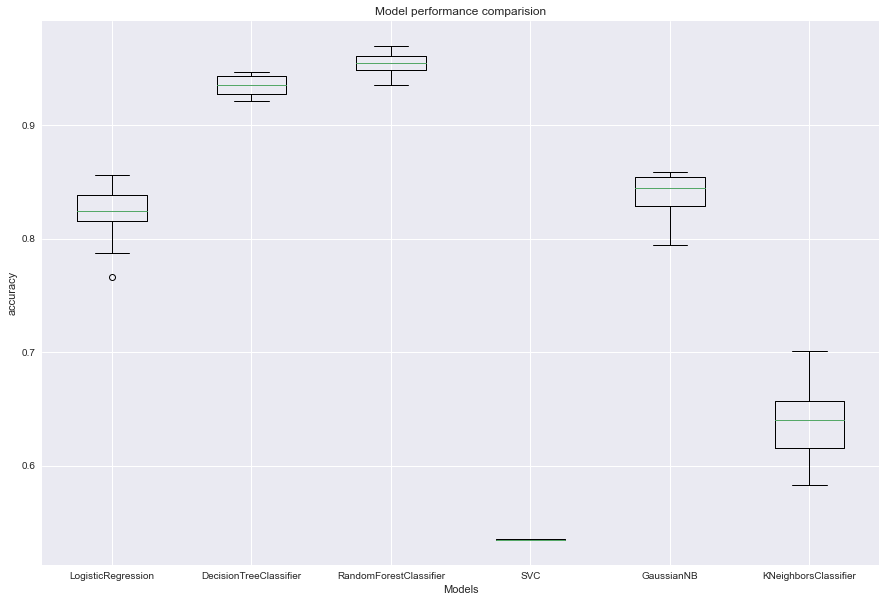

In [91]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision')
plt.show()

### Model considering only drivers

In [361]:
x_d= data[['GP_name','quali_pos','driver','age_at_gp_in_days','position','driver_confidence','active_driver']]

In [362]:
x_d = x_d[x_d['active_driver']==1]

In [179]:
print(driver_names)

['Daniel Ricciardo' 'Kevin Magnussen' 'Carlos Sainz' 'Valtteri Bottas'
 'Lance Stroll' 'George Russell' 'Lewis Hamilton' 'Sergio Pérez'
 'Lando Norris' 'Sebastian Vettel' 'Kimi Räikkönen' 'Charles Leclerc'
 'Daniil Kvyat' 'Max Verstappen' 'Pierre Gasly' 'Alexander Albon'
 'Esteban Ocon' 'Antonio Giovinazzi' 'Romain Grosjean' 'Nicholas Latifi']


In [239]:
x_d

,GP_name,quali_pos,driver,age_at_gp_in_days,position,driver_confidence,active_driver
39,Albert Park Grand Prix Circuit,12,Daniel Ricciardo,10851,12,0.942197,1
40,Albert Park Grand Prix Circuit,14,Kevin Magnussen,8567,15,0.952381,1
41,Albert Park Grand Prix Circuit,9,Carlos Sainz,8606,9,0.903846,1
90,Albert Park Grand Prix Circuit,16,Valtteri Bottas,8602,16,0.965035,1
91,Albert Park Grand Prix Circuit,15,Valtteri Bottas,8966,10,0.965035,1
...,...,...,...,...,...,...,...
8123,Buddh International Circuit,7,Kimi Räikkönen,12065,7,0.944099,1
8124,Buddh International Circuit,6,Kimi Räikkönen,12429,6,0.944099,1
8125,Buddh International Circuit,11,Romain Grosjean,9691,11,0.851852,1
8126,Buddh International Circuit,17,Romain Grosjean,10055,17,0.851852,1


In [195]:
x_d.to_csv('x_d.csv')

,GP_name,quali_pos,driver,age_at_gp_in_days,driver_confidence,driver_encoded
0,Bahrain International Circuit,4,Carlos Sainz,8606,0.903,0


In [363]:
import pandas as pd
import numpy as np

# assume x_d is the existing dataframe
new_data = pd.DataFrame({
    'GP_name': ['Bahrain International Circuit'],
    'quali_pos': [11],
    'driver': ['Lando Norris'],
    'age_at_gp_in_days': 8400 ,
    'position': [12],
    'driver_confidence': [0.91],
    'active_driver': [1],
    'is_test':[1]
})
x_d['is_test'] = np.where(x_d.index>=0, 0,1)
# add new_data to X_d and set 'is_test' column to 1 for the new rows
x_d = pd.concat([x_d, new_data], axis=0).reset_index(drop=True)


In [256]:
x_d.head()

,GP_name,quali_pos,driver,age_at_gp_in_days,position,driver_confidence,active_driver,is_test,driver_encoded
0,0,12,Daniel Ricciardo,0.658614,12,0.942197,1,0,4
1,0,14,Kevin Magnussen,-0.622334,15,0.952381,1,0,8
2,0,9,Carlos Sainz,-0.600461,9,0.903846,1,0,2
3,0,16,Valtteri Bottas,-0.602705,16,0.965035,1,0,19
4,0,15,Valtteri Bottas,-0.398561,10,0.965035,1,0,19


In [364]:
sc  = StandardScaler()
le = LabelEncoder()
x_d['driver_encoded'] = le.fit_transform(x_d['driver'])
# After label encoding
driver_nums = x_d['driver_encoded'].unique()
driver_names = x_d['driver'].unique()

# Create a dictionary that maps driver numbers to names
driver_dict = dict(zip(driver_nums, driver_names))
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
#x_d['driver'] = le.fit_transform(x_d['driver'])
x_d['GP_name'] = le.fit_transform(x_d['GP_name'])
x_d['age_at_gp_in_days'] = sc.fit_transform(x_d[['age_at_gp_in_days']])
X_d = x_d.drop(['active_driver'],1)
#y_d = x_d['position'].apply(lambda x: position_index(x))
y_d = x_d[x_d['is_test'] == 0]['position']

In [243]:
print(driver_dict)

{4: 'Daniel Ricciardo', 8: 'Kevin Magnussen', 2: 'Carlos Sainz', 19: 'Valtteri Bottas', 10: 'Lance Stroll', 7: 'George Russell', 12: 'Lewis Hamilton', 18: 'Sergio Pérez', 11: 'Lando Norris', 17: 'Sebastian Vettel', 9: 'Kimi Räikkönen', 3: 'Charles Leclerc', 5: 'Daniil Kvyat', 13: 'Max Verstappen', 15: 'Pierre Gasly', 0: 'Alexander Albon', 6: 'Esteban Ocon', 1: 'Antonio Giovinazzi', 16: 'Romain Grosjean', 14: 'Nicholas Latifi'}


In [300]:
X_d.head()

,GP_name,quali_pos,driver,age_at_gp_in_days,position,driver_confidence,is_test,driver_encoded
0,0,12,Daniel Ricciardo,0.658614,12,0.942197,0,4
1,0,14,Kevin Magnussen,-0.622334,15,0.952381,0,8
2,0,9,Carlos Sainz,-0.600461,9,0.903846,0,2
3,0,16,Valtteri Bottas,-0.602705,16,0.965035,0,19
4,0,15,Valtteri Bottas,-0.398561,10,0.965035,0,19


In [365]:
X_d = X_d.drop(['driver'], axis = 1)

In [45]:
y_d.shape

(1941,)

In [366]:
x_test = X_d[X_d['is_test'] == 1]
X_d = X_d[X_d['is_test'] == 0].drop(['position'], axis=1)

In [367]:
x_test = x_test.drop(['position'],axis = 1)

In [316]:
X_d

,GP_name,quali_pos,age_at_gp_in_days,driver_confidence,is_test,driver_encoded
0,0,12,0.658614,0.942197,0,4
1,0,14,-0.622334,0.952381,0,8
2,0,9,-0.600461,0.903846,0,2
3,0,16,-0.602705,0.965035,0,19
4,0,15,-0.398561,0.965035,0,19
...,...,...,...,...,...,...
1936,6,7,1.339468,0.944099,0,9
1937,6,6,1.543612,0.944099,0,9
1938,6,11,0.008045,0.851852,0,16
1939,6,17,0.212189,0.851852,0,16


In [303]:
X_d.head()

,GP_name,quali_pos,age_at_gp_in_days,driver_confidence,is_test,driver_encoded
0,0,12,0.658614,0.942197,0,4
1,0,14,-0.622334,0.952381,0,8
2,0,9,-0.600461,0.903846,0,2
3,0,16,-0.602705,0.965035,0,19
4,0,15,-0.398561,0.965035,0,19


In [ ]:
#cross validation for diffrent models
from sklearn.model_selection import cross_val_predict

# models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
models = [RandomForestClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results_dri = []
results_dri = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1, shuffle = True )
    result = cross_val_score(model,X_d,y_d,cv=cv,scoring='accuracy')
    mean_results_dri.append(result.mean())
    results_dri.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')
    y_pred = cross_val_predict(model, X_d, y_d, cv=cv)
    # map encoded driver labels back to their original names
    
    
    

In [327]:
#cross validation for diffrent models
from sklearn.model_selection import cross_val_predict

# models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
models = [RandomForestClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results_dri = []
results_dri = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1, shuffle = True )
    result = cross_val_score(model,X_d,y_d,cv=cv,scoring='accuracy')
    mean_results_dri.append(result.mean())
    results_dri.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')
    y_pred = cross_val_predict(model, X_d, y_d, cv=cv)
    # map encoded driver labels back to their original names
    # map encoded driver labels back to their original names
    driver_names = x_d['driver_encoded'].map(driver_dict)
    
    
    

C:\Users\tejde\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


LogisticRegression : 0.5868067671160454


C:\Users\tejde\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


KeyboardInterrupt: 

In [368]:
model = RandomForestClassifier()

cv = StratifiedKFold(n_splits=10,random_state=1, shuffle = True )
result = cross_val_score(model,X_d,y_d,cv=cv,scoring='accuracy')
model.fit(X_d,y_d)
y_pred = model.predict(x_test)
print(y_pred)

C:\Users\tejde\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


[11]


In [190]:
X_d

,GP_name,quali_pos,age_at_gp_in_days,driver_confidence,driver_encoded
39,0,12,0.658857,0.942197,4
40,0,14,-0.621904,0.952381,8
41,0,9,-0.600035,0.903846,2
90,0,16,-0.602278,0.965035,19
91,0,15,-0.398163,0.965035,19
...,...,...,...,...,...
8123,6,7,1.339612,0.944099,9
8124,6,6,1.543726,0.944099,9
8125,6,11,0.008383,0.851852,16
8126,6,17,0.212497,0.851852,16


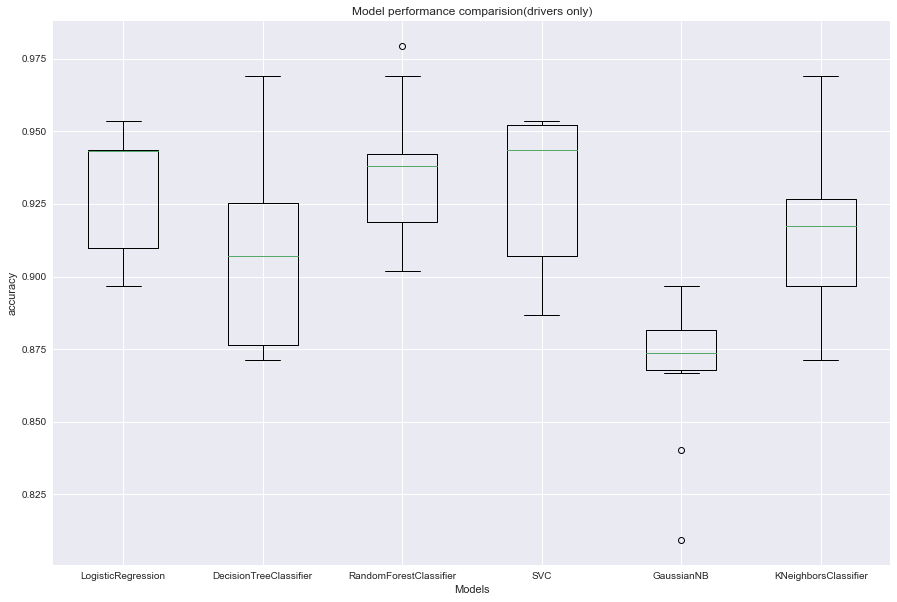

In [48]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results_dri,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision(drivers only)')
plt.show()

### Model considering only constructor

In [49]:
x_c = data[['GP_name','quali_pos','constructor','position','constructor_relaiblity','active_constructor']]

In [50]:
x_c = x_c[x_c['active_constructor']==1]

In [51]:
sc  = StandardScaler()
le = LabelEncoder()
x_c['GP_name'] = le.fit_transform(x_c['GP_name'])
x_c['constructor'] = le.fit_transform(x_c['constructor'])
X_c = x_c.drop(['position','active_constructor'],1)
y_c = x_c['position'].apply(lambda x: position_index(x))

In [83]:
X_c.dtypes

GP_name                     int64
quali_pos                   int64
constructor                 int64
constructor_relaiblity    float64
dtype: object

In [53]:
#cross validation for diffrent models
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),GaussianNB(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','GaussianNB','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results_const = []
results_const = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1, shuffle = True )
    result = cross_val_score(model,X_c,y_c,cv=cv,scoring='accuracy')
    mean_results_const.append(result.mean())
    results_const.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

C:\Users\tejde\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tejde\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression : 0.9336870026525199
DecisionTreeClassifier : 0.923872679045093
RandomForestClassifier : 0.9411140583554376
SVC : 0.9509283819628648
GaussianNB : 0.8702917771883287
KNeighborsClassifier : 0.9347480106100796


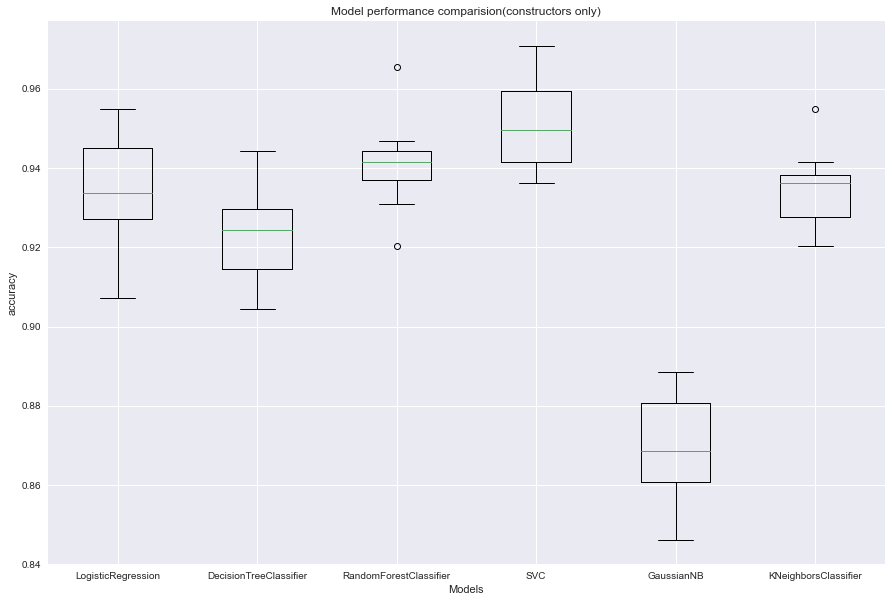

In [54]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results_const,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision(constructors only)')
plt.show()

#### lets see mean score of our three assumptions

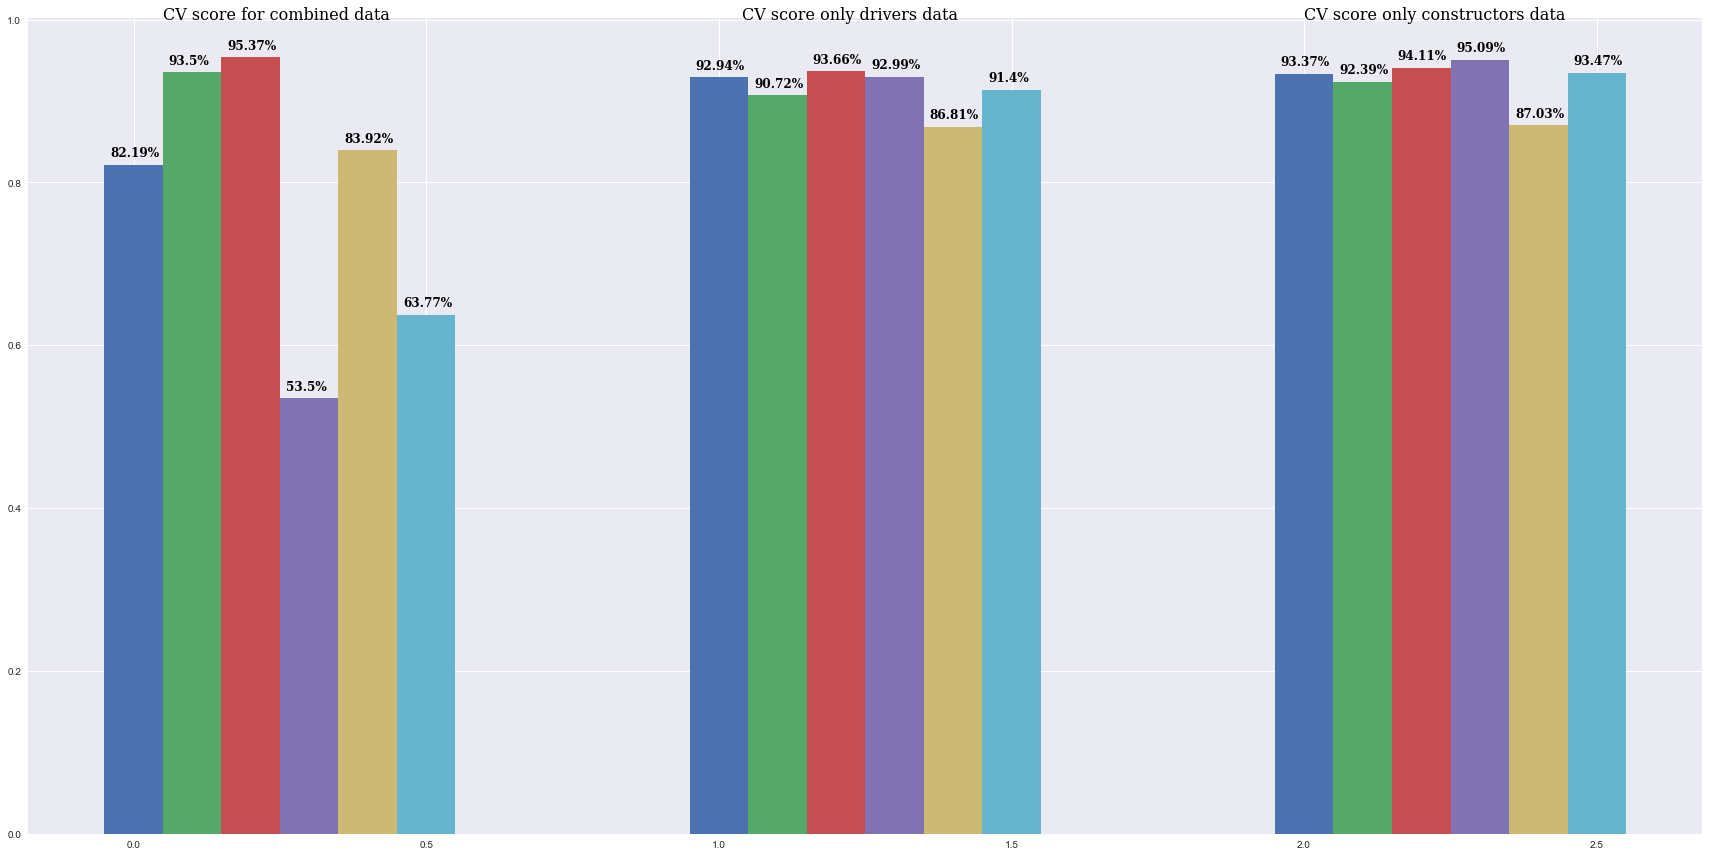

In [92]:
lr = [mean_results[0],mean_results_dri[0],mean_results_const[0]]
dtc = [mean_results[1],mean_results_dri[1],mean_results_const[1]]
rfc = [mean_results[2],mean_results_dri[2],mean_results_const[2]]
svc = [mean_results[3],mean_results_dri[3],mean_results_const[3]]
gnb = [mean_results[4],mean_results_dri[4],mean_results_const[4]]
knn = [mean_results[5],mean_results_dri[5],mean_results_const[5]]
font1 = {
    'family':'serif',
    'color':'black',
    'weight':'normal',
    'size':16
}
font2 = {
    'family':'serif',
    'color':'black',
    'weight':'bold',
    'size':12
}
x_ax = np.arange(3)
plt.figure(figsize=(30,15))
bar1 = plt.bar(x_ax,lr,width=0.1,align='center')
bar2 = plt.bar(x_ax+0.1,dtc,width=0.1,align='center')
bar3 = plt.bar(x_ax+0.2,rfc,width=0.1,align='center')
bar4 = plt.bar(x_ax+0.3,svc,width=0.1,align='center')
bar5 = plt.bar(x_ax+0.4,gnb,width=0.1,align='center')
bar6 = plt.bar(x_ax+0.5,knn,width=0.1,align='center')
plt.text(0.05,1,'CV score for combined data',fontdict=font1)
plt.text(1.04,1,'CV score only drivers data',fontdict=font1)
plt.text(2,1,'CV score only constructors data',fontdict=font1)
for bar in bar1.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar2.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar3.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar4.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar5.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
for bar in bar6.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.01,yval+0.01,f'{round(yval*100,2)}%',fontdict=font2)
plt.show()

In [24]:
n_estimators = [int(x) for x in np.linspace(start=200,stop=2000,num=10)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(10,110,num=11)]
min_samples_split = [2,5,8,10,15,20]
min_samples_leaf = [1,2,4,6,8,10]
bootstrap = [True,False]

random_parms = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap':bootstrap
                }

In [64]:
X.shape

(4323, 18)

In [124]:
y = np.array(y).reshape(-1, 1)
y = pd.Series(y.flatten())

In [125]:
y.shape

(4323,)

In [42]:
rf_rand = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf_rand,param_distributions=random_parms,n_iter=10,cv=10,verbose=2,n_jobs=-1 )
rf_random.fit(X,y)
rf_random.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [43]:
rf = RandomForestClassifier(n_estimators=1600,min_samples_split=8,min_samples_leaf=4,max_features='auto',max_depth=70,bootstrap=True)
kf = StratifiedKFold(n_splits=10,random_state=None,shuffle=False)
for train_index,test_index in kf.split(X,y):
    X_train,X_test = X.iloc[train_index],X.iloc[test_index]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]

In [180]:
X_test

,GP_name,quali_pos,constructor,driver,driver_confidence,constructor_relaiblity,istest
7655,24,3,2,11,0.933798,0.824359,0
7669,24,4,5,14,0.940711,0.877805,0
7670,24,5,5,14,0.940711,0.877805,0
7671,24,1,5,14,0.940711,0.877805,0
7672,24,1,5,25,0.965035,0.877805,0
...,...,...,...,...,...,...,...
8122,8,1,7,23,0.934156,0.750865,0
8123,8,7,8,11,0.933798,0.601852,0
8124,8,6,8,11,0.933798,0.601852,0
8125,8,11,8,22,0.852071,0.601852,0


In [4]:
data

,season,round,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,grid,podium,...,constructor_minardi,constructor_prost,constructor_red_bull,constructor_renault,constructor_sauber,constructor_team_lotus,constructor_toro_rosso,constructor_toyota,constructor_tyrrell,constructor_williams
0,1983,1,False,False,True,False,False,keke_rosberg,1,15,...,0,0,0,0,0,0,0,0,0,1
1,1983,1,False,False,True,False,False,prost,2,6,...,0,0,0,1,0,0,0,0,0,0
2,1983,1,False,False,True,False,False,tambay,3,4,...,0,0,0,0,0,0,0,0,0,0
3,1983,1,False,False,True,False,False,piquet,4,1,...,0,0,0,0,0,0,0,0,0,0
4,1983,1,False,False,True,False,False,warwick,5,7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15013,2023,4,True,False,False,False,True,sargeant,14,16,...,0,0,0,0,0,0,0,0,0,1
15014,2023,4,True,False,False,False,True,zhou,15,19,...,0,0,0,0,0,0,0,0,0,0
15015,2023,4,True,False,False,False,True,kevin_magnussen,16,13,...,0,0,0,0,0,0,0,0,0,0
15016,2023,4,True,False,False,False,True,gasly,17,14,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data.dtypes

season                    int64
round                     int64
weather_warm               bool
weather_cold               bool
weather_dry                bool
                          ...  
constructor_team_lotus    int64
constructor_toro_rosso    int64
constructor_toyota        int64
constructor_tyrrell       int64
constructor_williams      int64
Length: 100, dtype: object

In [117]:
data.columns

Index(['season', 'round', 'weather_warm', 'weather_cold', 'weather_dry',
       'weather_wet', 'weather_cloudy', 'driver', 'grid', 'podium',
       'driver_points', 'driver_wins', 'driver_standings_pos',
       'constructor_points', 'constructor_wins', 'constructor_standings_pos',
       'qualifying_time', 'driver_age', 'circuit_id_adelaide',
       'circuit_id_albert_park', 'circuit_id_americas', 'circuit_id_bahrain',
       'circuit_id_brands_hatch', 'circuit_id_catalunya', 'circuit_id_detroit',
       'circuit_id_estoril', 'circuit_id_galvez', 'circuit_id_hockenheimring',
       'circuit_id_hungaroring', 'circuit_id_imola', 'circuit_id_indianapolis',
       'circuit_id_interlagos', 'circuit_id_istanbul',
       'circuit_id_jacarepagua', 'circuit_id_jerez', 'circuit_id_kyalami',
       'circuit_id_magny_cours', 'circuit_id_marina_bay', 'circuit_id_monaco',
       'circuit_id_monza', 'circuit_id_nurburgring', 'circuit_id_phoenix',
       'circuit_id_red_bull_ring', 'circuit_id_ricard'

In [102]:
data = pd.read_csv('final_df.csv')

X = data.copy()

sc  = StandardScaler()
le = LabelEncoder()
X['driver'] = le.fit_transform(X['driver'])

X_train = X[(X['season'] < 2023) ].drop('podium',axis = 1)
y_train = X[X['season'] < 2023]['podium']

In [103]:
X_2023 = X[(X['season'] == 2023) & (X['round'] < 4)].drop('podium',axis = 1)
y_2023 = X[(X['season'] == 2023) & (X['round'] < 4)]['podium']

X_train = pd.concat([X_train,X_2023])
y_train = pd.concat([y_train,y_2023])

In [104]:
X_train

,season,round,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,grid,driver_points,...,constructor_minardi,constructor_prost,constructor_red_bull,constructor_renault,constructor_sauber,constructor_team_lotus,constructor_toro_rosso,constructor_toyota,constructor_tyrrell,constructor_williams
0,1983,1,False,False,True,False,False,109,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1983,1,False,False,True,False,False,176,2,0,...,0,0,0,1,0,0,0,0,0,0
2,1983,1,False,False,True,False,False,212,3,0,...,0,0,0,0,0,0,0,0,0,0
3,1983,1,False,False,True,False,False,171,4,0,...,0,0,0,0,0,0,0,0,0,0
4,1983,1,False,False,True,False,False,223,5,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2023,3,True,False,False,False,False,110,14,1,...,0,0,0,0,0,0,0,0,0,0
14996,2023,3,True,False,False,False,False,58,15,0,...,0,0,0,0,0,0,0,0,0,0
14997,2023,3,True,False,False,False,False,168,16,0,...,0,0,0,0,0,0,0,0,0,0
14998,2023,3,True,False,False,False,False,233,17,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
y_train

0        15
1         6
2         4
3         1
4         7
         ..
14995    17
14996    15
14997     8
14998     9
14999    16
Name: podium, Length: 15000, dtype: int64

In [ ]:
X_test['actualname'] = X_test[s]

In [106]:
X_test = X[(X['season'] == 2023) & (X['round'] == 4) & X['dr']].drop('podium',axis = 1)
y_test = X[(X['season'] == 2023) & (X['round'] == 4)]['podium']

In [91]:
X_test

,season,round,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,grid,driver_points,...,constructor_minardi,constructor_prost,constructor_red_bull,constructor_renault,constructor_sauber,constructor_team_lotus,constructor_toro_rosso,constructor_toyota,constructor_tyrrell,constructor_williams
15000,2023,4,True,False,False,False,True,126,1,0,...,0,0,0,0,0,0,0,0,0,0
15001,2023,4,True,False,False,False,True,139,2,44,...,0,0,1,0,0,0,0,0,0,0
15002,2023,4,True,False,False,False,True,166,3,18,...,0,0,1,0,0,0,0,0,0,0
15003,2023,4,True,False,False,False,True,189,4,20,...,0,0,0,0,0,0,0,0,0,0
15004,2023,4,True,False,False,False,True,93,5,20,...,0,0,0,0,0,0,0,0,0,0
15005,2023,4,True,False,False,False,True,8,6,30,...,0,0,0,0,0,0,0,0,0,0
15006,2023,4,True,False,False,False,True,159,7,0,...,0,0,0,0,0,0,0,0,0,0
15007,2023,4,True,False,False,False,True,216,8,0,...,0,0,0,0,0,0,0,0,0,0
15008,2023,4,True,False,False,False,True,206,9,8,...,0,0,0,0,0,0,0,0,0,0
15009,2023,4,True,False,False,False,True,168,10,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
y_test

15000     3
15001     2
15002     1
15003     5
15004     6
15005     4
15006     9
15007    10
15008     7
15009    11
15010     8
15011    12
15012    18
15013    16
15014    19
15015    13
15016    14
15017    20
Name: podium, dtype: int64

In [61]:
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
cnf_mat_rf = confusion_matrix(y_test,y_pred_rf)
cnf_mat_rf = cnf_mat_rf/cnf_mat_rf.sum()

C:\Users\tejde\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


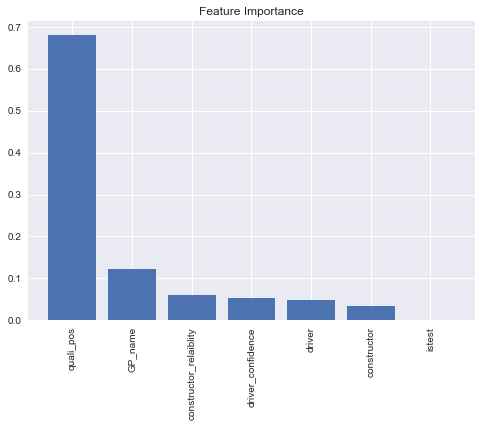

In [29]:
# Get feature importances
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

# Load your data and split it into training and testing sets

# Train a random forest classifier with varying numbers of trees
n_trees = [100, 400, 600, 800, 1600, 2000, 5000]
train_acc = []
test_acc = []
for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n,min_samples_split=8,min_samples_leaf=4,max_features='auto',max_depth=70,bootstrap=True)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))




C:\Users\tejde\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\tejde\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\tejde\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

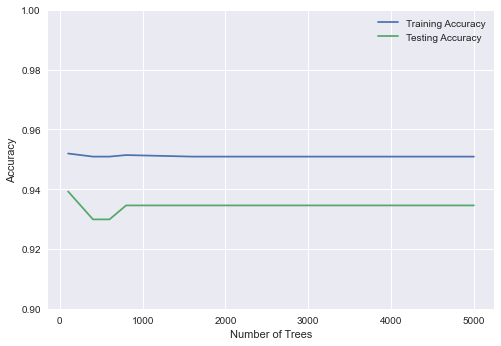

In [58]:
# Plot the accuracy as a function of the number of trees
plt.plot(n_trees, train_acc, label='Training Accuracy')
plt.ylim([0.9,1])
plt.plot(n_trees, test_acc, label='Testing Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

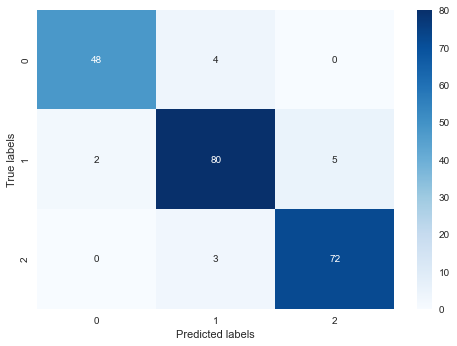

In [62]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# assume y_true and y_pred are the true and predicted labels
cm = confusion_matrix(y_test, y_pred_rf)

# plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [119]:
import pickle

filename = 'rf_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(rf, file)

In [52]:
y_pred_new = rf.predict(X_test_new)

NameError: name 'X_test_new' is not defined

In [94]:
print(y_pred_rf)

[ 4  1  1  6  3  3  6 10  5  6  5 19 14 16 14 17 13 15]


In [95]:
X_later = X_test.copy()
X_later = X_later[['season','round','driver','grid']]

X_later['pred_pos'] = y_pred_rf
X_later['actual'] = y_test

In [96]:
X_later = X_later.sort_values(by = 'pred_pos')

In [97]:
X_later.shape

(18, 6)

In [98]:
X_later['pred_pos'] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

In [99]:
X_later['driver'] = le.inverse_transform(X_later['driver'])

In [100]:
X_later ## jeddah 2022

,season,round,driver,grid,pred_pos,actual
15001,2023,4,max_verstappen,2,1,2
15002,2023,4,perez,3,2,1
15004,2023,4,hamilton,5,3,6
15005,2023,4,alonso,6,4,4
15000,2023,4,leclerc,1,5,3
15010,2023,4,russell,11,6,8
15008,2023,4,stroll,9,7,7
15009,2023,4,piastri,10,8,11
15003,2023,4,sainz,4,9,5
15006,2023,4,norris,7,10,9


In [101]:
X_later

,season,round,driver,grid,pred_pos,actual
15001,2023,4,max_verstappen,2,1,2
15002,2023,4,perez,3,2,1
15004,2023,4,hamilton,5,3,6
15005,2023,4,alonso,6,4,4
15000,2023,4,leclerc,1,5,3
15010,2023,4,russell,11,6,8
15008,2023,4,stroll,9,7,7
15009,2023,4,piastri,10,8,11
15003,2023,4,sainz,4,9,5
15006,2023,4,norris,7,10,9


In [226]:
new_data_tested = new_data.copy()
new_data_tested['pos'] = y_pred_new

In [227]:
new_data_tested = new_data_tested.sort_values(by='pos', ascending=True)
new_data_tested['pos'] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]


In [228]:
new_data_tested

,GP_name,quali_pos,constructor,driver,driver_confidence,constructor_relaiblity,active_driver,active_constructor,dob,istest,pos
0,Baku City Circuit,1,Ferrari,Charles Leclerc,0.844444,0.824359,1,1,1,1,1
1,Baku City Circuit,2,Red Bull,Max Verstappen,0.914286,0.750865,1,1,1,1,2
2,Baku City Circuit,3,Red Bull,Sergio Pérez,0.933333,0.750865,1,1,1,1,3
3,Baku City Circuit,4,Ferrari,Carlos Sainz Jr.,0.903846,0.824359,1,1,1,1,4
4,Baku City Circuit,5,Mercedes,Lewis Hamilton,0.940711,0.877805,1,1,1,1,5
5,Baku City Circuit,6,Racing Point,Fernando Alonso,0.800000,0.590234,1,1,1,1,6
6,Baku City Circuit,7,McLaren,Lando Norris,0.916667,0.634492,1,1,1,1,7
7,Baku City Circuit,8,AlphaTauri,Yuki Tsunoda,0.800000,0.455390,1,1,1,1,8
8,Baku City Circuit,9,Racing Point,Lance Stroll,0.923077,0.590234,1,1,1,1,9
10,Baku City Circuit,11,Mercedes,George Russell,0.958333,0.877805,1,1,1,1,10


In [38]:
X.dtypes

GP_name                            int64
quali_pos                          int64
constructor                        int32
driver                             int32
driver_confidence                float64
constructor_relaiblity           float64
dob                       datetime64[ns]
dtype: object

In [79]:
X_d.dtypes

GP_name                int64
quali_pos              int64
driver                 int64
age_at_gp_in_days    float64
driver_confidence    float64
dtype: object

In [48]:
X.drop(["country", "constructor_nationality"], axis=1, inplace=True)


In [39]:
X = X.drop([ 'dob'], axis=1)


In [50]:
X = X.drop(['driver_nationality'],axis = 1)

In [51]:
X['age_at_gp_in_days'] = X['age_at_gp_in_days'].apply(lambda x: float(x.split()[0]))


In [59]:
svc = SVC()
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
svc.fit(X_train,y_train)
y_pred_svc = svc.predict(X_test)
cnf_mat_svc = confusion_matrix(y_test,y_pred)
cnf_mat_svc = cnf_mat_svc/cnf_mat_svc.sum()

In [110]:
X_later = X_test.copy()
X_later = X_later[['season','round','driver','grid']]

X_later['pred_pos'] = y_pred_rf
X_later['actual'] = y_test

X_later = X_later.sort_values(by = 'pred_pos')

In [111]:
X_later.shape

(18, 6)

In [114]:
X_later['driver'] = le.inverse_transform(X_later['driver'])

In [112]:
X_later['pred_pos'] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

In [115]:
X_later

,season,round,driver,grid,pred_pos,actual
15001,2023,4,max_verstappen,2,1,2
15002,2023,4,perez,3,2,1
15004,2023,4,hamilton,5,3,6
15005,2023,4,alonso,6,4,4
15000,2023,4,leclerc,1,5,3
15010,2023,4,russell,11,6,8
15008,2023,4,stroll,9,7,7
15009,2023,4,piastri,10,8,11
15003,2023,4,sainz,4,9,5
15006,2023,4,norris,7,10,9


In [109]:
print(y_pred_svc)

[13  7  7 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]


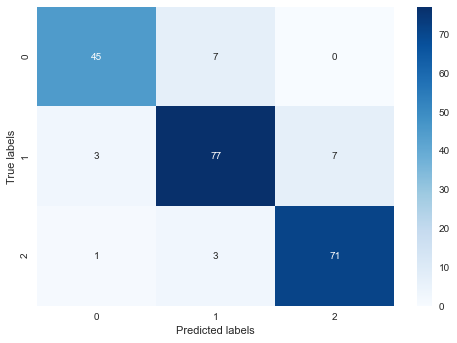

In [64]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# assume y_true and y_pred are the true and predicted labels
cm = confusion_matrix(y_test, y_pred_svc)

# plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [65]:
rf_pression = precision_score(y_test, y_pred_rf, average='macro')
rf_f1 = f1_score(y_test,y_pred_rf,average='macro')
rf_recall = recall_score(y_test,y_pred_rf,average='macro')
svc_pression = precision_score(y_test, y_pred_svc, average='micro')
svc_f1 = f1_score(y_test,y_pred_svc,average='macro')
svc_recall = recall_score(y_test,y_pred_svc,average='macro')
metrics_dict ={
    'RandomForestClassifier':{'precision_score':rf_pression,'f1_score':rf_f1,'recall_score':rf_recall},
    'SVC':{'precision_score':svc_pression,'f1_score':svc_f1,'recall_score':svc_recall}
}
metrics_df = pd.DataFrame(metrics_dict)
metrics_df

,RandomForestClassifier,SVC
precision_score,0.938202,0.901869
f1_score,0.936028,0.901417
recall_score,0.934206,0.899036
